In [1]:
import os
import pygame
import random
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "1"

# Initialisation de Pygame
pygame.init()

(5, 0)

In [3]:
from utils import *
from Taxi_class import *
from task_class import *

NUM_TASKS = 20
NUM_NEW_TASKS = 5

In [4]:
def bid_for_tasks(taxi, tasks):
    bids = {}
    pos = taxi.position
    if taxi.current_task:
        pos = taxi.current_task.end
    for task in tasks:
        if not task.taken:  # Seules les tâches disponibles sont mises aux enchères
            distance = ((pos[0] - task.start[0])**2 + (pos[1] - task.start[1])**2) ** 0.5
            bids[task] = distance  # L'enchère est basée sur la distance (plus petite = meilleure offre)
    return bids

def bid_for_task(taxi, task, pos):
        distance = ((pos[0] - task.start[0])**2 + (pos[1] - task.start[1])**2) ** 0.5
        return distance

In [5]:
def psi_auction(taxis, tasks):
    # Collecte des enchères de tous les taxis
    all_bids = []
    for taxi in taxis:
        all_bids.append((taxi, bid_for_tasks(taxi, tasks)))

    # Attribution des tâches aux meilleurs enchérisseurs
    task_allocations = {}
    for taxi, bids in all_bids:
        for task, bid in bids.items():
            if task not in task_allocations or bid < task_allocations[task][1]:
                task_allocations[task] = (taxi, bid)

    # Assigner les tâches gagnées
    for task, (winning_taxi, bid) in task_allocations.items():
        if not task.allocated:
            for t in taxis:
                if t.has_task(task):
                    t.remove_task(task)
            winning_taxi.assign_task(task, ordering=True)
            task.allocate()

In [6]:
# Initialisation de la fenêtre
screen = pygame.display.set_mode((WINDOW_SIZE + INFO_PANEL_WIDTH, WINDOW_SIZE))
pygame.display.set_caption("Simulation de taxis")

In [7]:
# Génération aléatoire de taxis et de tâches
taxis = [
    Taxi((random.randint(0, GRID_SIZE), random.randint(0, GRID_SIZE)), f"T{i+1}")
    for i in range(NUM_TAXIS)
]

algo_list = []
execution_time_list = []
mean_waiting_time_list = []
min_waiting_time_list = []
max_waiting_time_list = []
total_distance_list = []

In [8]:
num_groups = NUM_TASKS // NUM_NEW_TASKS

total_tasks = generate_tasks(num_tasks=NUM_TASKS, num_groups=num_groups, grid_size=GRID_SIZE)
tasks = []
current_group = 0

running = True
step = 0

In [9]:
# Boucle principale
start = time.time()
clock = pygame.time.Clock()

while current_group < num_groups + 1 or len(tasks) > 0:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Dessin de l'environnement
    screen.fill(GREY)

    if step % (T * FPS)  == 0:

        new_tasks = total_tasks[current_group * (NUM_TASKS // num_groups): (current_group + 1) * (NUM_TASKS // num_groups)]
        for task in new_tasks:
            tasks.append(task)
        current_group += 1

        available_tasks = [task for task in tasks if not task.taken and not task.allocated]
        psi_auction(taxis, available_tasks)

    # Déplacement des taxis
    for taxi in taxis:
        taxi.update()
        taxi.draw(screen)

    # Dessin des tâches
    for task in tasks:
        if task.completed:
            tasks.remove(task)
            continue
        
        task.update()
        task.draw(screen)

    draw_task_allocations(screen, taxis, WINDOW_SIZE)

    pygame.display.flip()
    clock.tick(FPS)
    step += 1


execution_time = time.time() - start
mean_waiting_time = Task.waiting_time_sum / Task.nb_tasks
max_waiting_time = Task.waiting_time_max
min_waiting_time = Task.waiting_time_min
total_distance = sum([taxi.total_distance for taxi in taxis])

algo_list.append("psi_auction")
execution_time_list.append(execution_time)
mean_waiting_time_list.append(mean_waiting_time)
max_waiting_time_list.append(max_waiting_time)
min_waiting_time_list.append(min_waiting_time)
total_distance_list.append(total_distance)

print(f"Fréquence de rafraîchissement : {FPS} FPS")
print(f"Temps d'exécution : {time.time() - start:.2f} secondes")
print(f"Temps d'attente moyen des taches : {(Task.waiting_time_sum / Task.nb_tasks)/FPS:.2f} secondes")
print(f"Temps d'attente max des taches : {Task.waiting_time_max/FPS:.2f} secondes")
print(f"Temps d'attente min des taches : {Task.waiting_time_min/FPS:.2f} secondes")
print(f"Distance totale parcourue par les taxis : {sum([taxi.total_distance for taxi in taxis]):.2f}")

Fréquence de rafraîchissement : 60 FPS
Temps d'exécution : 39.06 secondes
Temps d'attente moyen des taches : 4.35 secondes
Temps d'attente max des taches : 18.28 secondes
Temps d'attente min des taches : 0.25 secondes
Distance totale parcourue par les taxis : 3726.76


In [10]:
def evaluate_cost(taxi, task, heuristic):
    """
    Évalue le coût d'ajout d'une tâche à un taxi selon l'heuristique choisie.
    """
    if heuristic == "prim":
        return prim_cost(taxi, task)
    elif heuristic == "insertion":
        return insertion_cost(taxi, task)
    else:
        raise ValueError("Heuristique inconnue")
    
def prim_cost(taxi, task):
    """
    Retourne le coût d'ajout de la tâche selon l'heuristique de Prim.
    """
    if not taxi.path:
        return distance(taxi.position, task.start)
    
    # Cherche la tâche déjà assignée la plus proche de la nouvelle tâche
    min_dist = min(distance(t.start, task.start) for t in taxi.path)
    return min_dist

def insertion_cost(taxi, task):
    """
    Retourne le coût d'ajout de la tâche selon l'heuristique d'insertion.
    """
    if not taxi.path:
        return distance(taxi.position, task.start)  # Si aucune tâche, on prend la distance directe

    best_increase = float("inf")

    for i in range(len(taxi.path) + 1):
        new_path = taxi.path[:i] + [task] + taxi.path[i:]
        cost = taxi.compute_path_cost(new_path)

        if cost < best_increase:
            best_increase = cost

    return best_increase

In [11]:
def ssi_auction(taxis, tasks, heuristic="prim"):
    unassigned_tasks = tasks[:]  # Copie des tâches restantes

    while unassigned_tasks:
        task = unassigned_tasks.pop(0)  # Prend la première tâche disponible
        best_taxi = None
        best_cost = float("inf")

        for taxi in taxis:
            cost = evaluate_cost(taxi, task, heuristic)

            if cost < best_cost:
                best_cost = cost
                best_taxi = taxi

        if best_taxi:
            best_taxi.assign_task(task, ordering=True)  # Assigner la tâche au meilleur taxi
            task.allocate()  # Marquer la tâche comme allouée

In [12]:
num_groups = NUM_TASKS // NUM_NEW_TASKS

Task.nb_tasks = 0
Task.waiting_time_sum = 0
Task.waiting_time_max = 0
Task.waiting_time_min = float('inf')

total_tasks = generate_tasks(num_tasks=NUM_TASKS, num_groups=num_groups, grid_size=GRID_SIZE)
tasks = []
current_group = 0

running = True
step = 0
for taxi in taxis:
    taxi.total_distance = 0

In [13]:
# Boucle principale
start = time.time()
clock = pygame.time.Clock()

while current_group < num_groups + 1 or len(tasks) > 0:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Dessin de l'environnement
    screen.fill(GREY)

    if step % (T * FPS)  == 0:

        new_tasks = total_tasks[current_group * (NUM_TASKS // num_groups): (current_group + 1) * (NUM_TASKS // num_groups)]
        for task in new_tasks:
            tasks.append(task)
        current_group += 1

        available_tasks = [task for task in tasks if not task.taken and not task.allocated]
        ssi_auction(taxis, available_tasks)

    # Déplacement des taxis
    for taxi in taxis:
        taxi.update()
        taxi.draw(screen)

    # Dessin des tâches
    for task in tasks:
        if task.completed:
            tasks.remove(task)
            continue
        
        task.update()
        task.draw(screen)

    draw_task_allocations(screen, taxis, WINDOW_SIZE)

    pygame.display.flip()
    clock.tick(FPS)
    step += 1

execution_time = time.time() - start
mean_waiting_time = Task.waiting_time_sum / Task.nb_tasks
max_waiting_time = Task.waiting_time_max
min_waiting_time = Task.waiting_time_min
total_distance = sum([taxi.total_distance for taxi in taxis])

algo_list.append("ssi(prim)")
execution_time_list.append(execution_time)
mean_waiting_time_list.append(mean_waiting_time)
max_waiting_time_list.append(max_waiting_time)
min_waiting_time_list.append(min_waiting_time)
total_distance_list.append(total_distance)

print(f"Fréquence de rafraîchissement : {FPS} FPS")
print(f"Temps d'exécution : {time.time() - start:.2f} secondes")
print(f"Temps d'attente moyen des taches : {(Task.waiting_time_sum / Task.nb_tasks)/FPS:.2f} secondes")
print(f"Temps d'attente max des taches : {Task.waiting_time_max/FPS:.2f} secondes")
print(f"Temps d'attente min des taches : {Task.waiting_time_min/FPS:.2f} secondes")
print(f"Distance totale parcourue par les taxis : {sum([taxi.total_distance for taxi in taxis]):.2f}")

Fréquence de rafraîchissement : 60 FPS
Temps d'exécution : 39.75 secondes
Temps d'attente moyen des taches : 4.40 secondes
Temps d'attente max des taches : 12.30 secondes
Temps d'attente min des taches : 0.58 secondes
Distance totale parcourue par les taxis : 4014.90


In [14]:
num_groups = NUM_TASKS // NUM_NEW_TASKS

Task.nb_tasks = 0
Task.waiting_time_sum = 0
Task.waiting_time_max = 0
Task.waiting_time_min = float('inf')

total_tasks = generate_tasks(num_tasks=NUM_TASKS, num_groups=num_groups, grid_size=GRID_SIZE)
tasks = []
current_group = 0

running = True
step = 0
for taxi in taxis:
    taxi.total_distance = 0

In [15]:
# Boucle principale
start = time.time()
clock = pygame.time.Clock()

while current_group < num_groups + 1 or len(tasks) > 0:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Dessin de l'environnement
    screen.fill(GREY)

    if step % (T * FPS)  == 0:

        new_tasks = total_tasks[current_group * (NUM_TASKS // num_groups): (current_group + 1) * (NUM_TASKS // num_groups)]
        for task in new_tasks:
            tasks.append(task)
        current_group += 1

        available_tasks = [task for task in tasks if not task.taken and not task.allocated]
        ssi_auction(taxis, available_tasks, "insertion")

    # Déplacement des taxis
    for taxi in taxis:
        taxi.update()
        taxi.draw(screen)

    # Dessin des tâches
    for task in tasks:
        if task.completed:
            tasks.remove(task)
            continue
        
        task.update()
        task.draw(screen)

    draw_task_allocations(screen, taxis, WINDOW_SIZE)

    pygame.display.flip()
    clock.tick(FPS)
    step += 1

execution_time = time.time() - start
mean_waiting_time = Task.waiting_time_sum / Task.nb_tasks
max_waiting_time = Task.waiting_time_max
min_waiting_time = Task.waiting_time_min
total_distance = sum([taxi.total_distance for taxi in taxis])

algo_list.append("ssi(insertion)")
execution_time_list.append(execution_time)
mean_waiting_time_list.append(mean_waiting_time)
max_waiting_time_list.append(max_waiting_time)
min_waiting_time_list.append(min_waiting_time)
total_distance_list.append(total_distance)

print(f"Fréquence de rafraîchissement : {FPS} FPS")
print(f"Temps d'exécution : {time.time() - start:.2f} secondes")
print(f"Temps d'attente moyen des taches : {(Task.waiting_time_sum / Task.nb_tasks)/FPS:.2f} secondes")
print(f"Temps d'attente max des taches : {Task.waiting_time_max/FPS:.2f} secondes")
print(f"Temps d'attente min des taches : {Task.waiting_time_min/FPS:.2f} secondes")
print(f"Distance totale parcourue par les taxis : {sum([taxi.total_distance for taxi in taxis]):.2f}")

Fréquence de rafraîchissement : 60 FPS
Temps d'exécution : 39.00 secondes
Temps d'attente moyen des taches : 2.27 secondes
Temps d'attente max des taches : 4.68 secondes
Temps d'attente min des taches : 0.47 secondes
Distance totale parcourue par les taxis : 3885.31


In [16]:
def find_best_and_second_best_bid(taxis, task, heuristic):
    """
    Trouve le meilleur et le deuxième meilleur taxi pour une tâche donnée.
    
    Retourne :
    - best_taxi : le taxi avec la meilleure offre
    - best_cost : coût de l’offre du meilleur taxi
    - second_best_cost : coût de l’offre du second meilleur taxi
    """
    best_taxi = None
    best_cost = float("inf")
    second_best_cost = float("inf")

    for taxi in taxis:
        cost = evaluate_cost(taxi, task, heuristic)

        if cost < best_cost:
            second_best_cost = best_cost  # L’ancien meilleur devient le second meilleur
            best_cost = cost
            best_taxi = taxi
        elif cost < second_best_cost:
            second_best_cost = cost  # Mise à jour du second meilleur coût

    return best_taxi, best_cost, second_best_cost

In [17]:
def ssi_auction_with_regret(taxis, tasks, heuristic="prim"):
    unassigned_tasks = tasks[:]  # Copie des tâches restantes

    while unassigned_tasks:
        # Calcul des regrets pour chaque tâche
        task_regrets = []

        for task in unassigned_tasks:
            best_taxi, best_cost, second_best_cost = find_best_and_second_best_bid(taxis, task, heuristic)
            regret = second_best_cost - best_cost  # Calcul du regret

            if best_taxi:
                task_regrets.append((task, best_taxi, best_cost, regret))

        # Trier les tâches par regret décroissant
        task_regrets.sort(key=lambda x: x[3], reverse=True)

        if not task_regrets:
            break  # Plus aucune tâche attribuable

        # Prendre la tâche avec le plus grand regret
        selected_task, winning_taxi, best_cost, regret = task_regrets[0]

        # Assigner la tâche au meilleur taxi
        winning_taxi.assign_task(selected_task, ordering=True)
        selected_task.allocate()
        unassigned_tasks.remove(selected_task)

In [18]:
num_groups = NUM_TASKS // NUM_NEW_TASKS

Task.nb_tasks = 0
Task.waiting_time_sum = 0
Task.waiting_time_max = 0
Task.waiting_time_min = float('inf')

total_tasks = generate_tasks(num_tasks=NUM_TASKS, num_groups=num_groups, grid_size=GRID_SIZE)
tasks = []
current_group = 0

running = True
step = 0
for taxi in taxis:
    taxi.total_distance = 0

In [19]:
# Boucle principale
start = time.time()
clock = pygame.time.Clock()

while current_group < num_groups + 1 or len(tasks) > 0:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Dessin de l'environnement
    screen.fill(GREY)

    if step % (T * FPS)  == 0:

        new_tasks = total_tasks[current_group * (NUM_TASKS // num_groups): (current_group + 1) * (NUM_TASKS // num_groups)]
        for task in new_tasks:
            tasks.append(task)
        current_group += 1

        available_tasks = [task for task in tasks if not task.taken and not task.allocated]
        ssi_auction_with_regret(taxis, available_tasks)

    # Déplacement des taxis
    for taxi in taxis:
        taxi.update()
        taxi.draw(screen)

    # Dessin des tâches
    for task in tasks:
        if task.completed:
            tasks.remove(task)
            continue
        
        task.update()
        task.draw(screen)

    draw_task_allocations(screen, taxis, WINDOW_SIZE)

    pygame.display.flip()
    clock.tick(FPS)
    step += 1

execution_time = time.time() - start
mean_waiting_time = Task.waiting_time_sum / Task.nb_tasks
max_waiting_time = Task.waiting_time_max
min_waiting_time = Task.waiting_time_min
total_distance = sum([taxi.total_distance for taxi in taxis])

algo_list.append("regret(prim)")
execution_time_list.append(execution_time)
mean_waiting_time_list.append(mean_waiting_time)
max_waiting_time_list.append(max_waiting_time)
min_waiting_time_list.append(min_waiting_time)
total_distance_list.append(total_distance)

print(f"Fréquence de rafraîchissement : {FPS} FPS")
print(f"Temps d'exécution : {time.time() - start:.2f} secondes")
print(f"Temps d'attente moyen des taches : {(Task.waiting_time_sum / Task.nb_tasks)/FPS:.2f} secondes")
print(f"Temps d'attente max des taches : {Task.waiting_time_max/FPS:.2f} secondes")
print(f"Temps d'attente min des taches : {Task.waiting_time_min/FPS:.2f} secondes")
print(f"Distance totale parcourue par les taxis : {sum([taxi.total_distance for taxi in taxis]):.2f}")

Fréquence de rafraîchissement : 60 FPS
Temps d'exécution : 54.55 secondes
Temps d'attente moyen des taches : 9.64 secondes
Temps d'attente max des taches : 37.32 secondes
Temps d'attente min des taches : 0.45 secondes
Distance totale parcourue par les taxis : 3848.46


In [20]:
num_groups = NUM_TASKS // NUM_NEW_TASKS

Task.nb_tasks = 0
Task.waiting_time_sum = 0
Task.waiting_time_max = 0
Task.waiting_time_min = float('inf')

total_tasks = generate_tasks(num_tasks=NUM_TASKS, num_groups=num_groups, grid_size=GRID_SIZE)
tasks = []
current_group = 0

running = True
step = 0
for taxi in taxis:
    taxi.total_distance = 0

In [21]:
# Boucle principale
start = time.time()
clock = pygame.time.Clock()

while current_group < num_groups + 1 or len(tasks) > 0:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Dessin de l'environnement
    screen.fill(GREY)

    if step % (T * FPS)  == 0:

        new_tasks = total_tasks[current_group * (NUM_TASKS // num_groups): (current_group + 1) * (NUM_TASKS // num_groups)]
        for task in new_tasks:
            tasks.append(task)
        current_group += 1

        available_tasks = [task for task in tasks if not task.taken and not task.allocated]
        ssi_auction_with_regret(taxis, available_tasks, "insertion")

    # Déplacement des taxis
    for taxi in taxis:
        taxi.update()
        taxi.draw(screen)

    # Dessin des tâches
    for task in tasks:
        if task.completed:
            tasks.remove(task)
            continue
        
        task.update()
        task.draw(screen)

    draw_task_allocations(screen, taxis, WINDOW_SIZE)

    pygame.display.flip()
    clock.tick(FPS)
    step += 1

execution_time = time.time() - start
mean_waiting_time = Task.waiting_time_sum / Task.nb_tasks
max_waiting_time = Task.waiting_time_max
min_waiting_time = Task.waiting_time_min
total_distance = sum([taxi.total_distance for taxi in taxis])

algo_list.append("regret(insertion)")
execution_time_list.append(execution_time)
mean_waiting_time_list.append(mean_waiting_time)
max_waiting_time_list.append(max_waiting_time)
min_waiting_time_list.append(min_waiting_time)
total_distance_list.append(total_distance)

print(f"Fréquence de rafraîchissement : {FPS} FPS")
print(f"Temps d'exécution : {time.time() - start:.2f} secondes")
print(f"Temps d'attente moyen des taches : {(Task.waiting_time_sum / Task.nb_tasks)/FPS:.2f} secondes")
print(f"Temps d'attente max des taches : {Task.waiting_time_max/FPS:.2f} secondes")
print(f"Temps d'attente min des taches : {Task.waiting_time_min/FPS:.2f} secondes")
print(f"Distance totale parcourue par les taxis : {sum([taxi.total_distance for taxi in taxis]):.2f}")

Fréquence de rafraîchissement : 60 FPS
Temps d'exécution : 39.03 secondes
Temps d'attente moyen des taches : 2.42 secondes
Temps d'attente max des taches : 5.23 secondes
Temps d'attente min des taches : 0.58 secondes
Distance totale parcourue par les taxis : 3863.61


In [22]:
pygame.quit()

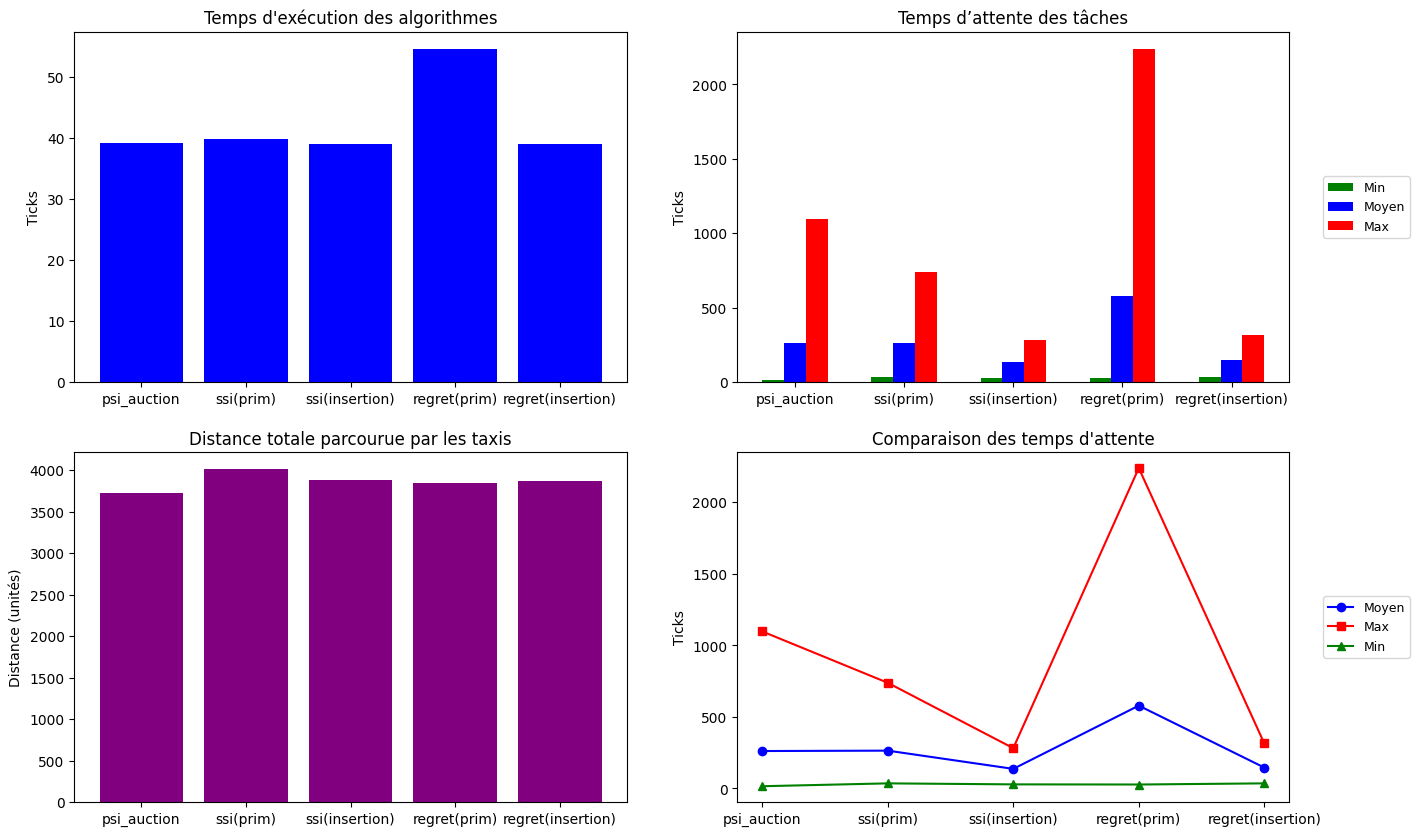

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# 1. Temps d'exécution
axes[0, 0].bar(algo_list, execution_time_list, color="blue")
axes[0, 0].set_title("Temps d'exécution des algorithmes")
axes[0, 0].set_ylabel("Ticks")

# 2. Temps d’attente (min, max, moyen)
x = np.arange(len(algo_list))  
width = 0.2  

axes[0, 1].bar(x - width, min_waiting_time_list, width, label="Min", color="green")
axes[0, 1].bar(x, mean_waiting_time_list, width, label="Moyen", color="blue")
axes[0, 1].bar(x + width, max_waiting_time_list, width, label="Max", color="red")

axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(algo_list)
axes[0, 1].set_title("Temps d’attente des tâches")
axes[0, 1].set_ylabel("Ticks")
axes[0, 1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=9)  

# 3. Distance totale parcourue
axes[1, 0].bar(algo_list, total_distance_list, color="purple")
axes[1, 0].set_title("Distance totale parcourue par les taxis")
axes[1, 0].set_ylabel("Distance (unités)")

# 4. Comparaison des temps d’attente (courbes)
axes[1, 1].plot(algo_list, mean_waiting_time_list, marker='o', label="Moyen", color="blue")
axes[1, 1].plot(algo_list, max_waiting_time_list, marker='s', label="Max", color="red")
axes[1, 1].plot(algo_list, min_waiting_time_list, marker='^', label="Min", color="green")

axes[1, 1].set_title("Comparaison des temps d'attente")
axes[1, 1].set_ylabel("Ticks")
axes[1, 1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=9)  

plt.subplots_adjust(right=0.8)  

# Affichage
plt.show()
